In [12]:
import os
import math
import time
import glob
import warnings
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import torch
from fastai.vision.all import *
from PIL import Image
from imgaug import augmenters as iaa
import cv2
from builtins import range
from skimage.io import imread

import tensorflow as tf
from tensorflow.keras import applications, backend, callbacks, layers
from tensorflow.keras import models, metrics, optimizers, preprocessing
from tensorflow.keras import regularizers, utils
from tensorflow.keras.preprocessing import image

from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

ModuleNotFoundError: No module named 'fastai.vision.all'

In [5]:
# Seed randomness for reproducibility
SEED = 42
tf.random.set_seed(SEED)
rs = np.random.RandomState(np.random.MT19937(np.random.SeedSequence(SEED)))

# Suppress warnings
warnings.filterwarnings("ignore")

# Hyperparameters
EPOCHS = 3
PATIENCE = 4
BATCH_SIZE = 50
VALIDATION_FRAC = 0.30
INIT_LEARN_RATE = 0.01
FREEZE_LAYERS_FRAC = 0.94

# Inputs 
COLOR_MODE = 'grayscale'
INTERPOLATION = 'hamming'

TRAIN_DOWNSAMPLE_FRAC = 1.00

SCALE_DIM = 2 # Tested 1-7
XCEPT_DIM = 299
IMAGE_SIZE = (SCALE_DIM * XCEPT_DIM,
              SCALE_DIM * XCEPT_DIM)
IMAGE_SHAPE = IMAGE_SIZE + (1,)


# Classes
CLASS_H = 'Healthy'
CLASS_VPNA = 'Viral PNA'
CLASS_BPNA = 'Bacterial PNA'

# Stages
STAGE_TRAIN = 'train'
STAGE_VAL = 'val'
STAGE_TEST = 'test'

# Pathing
DATA_PATH = '../dataset'
# DATA_PATHCNN = Path('C:\\Users\\donquijote\\Desktop\\IA\\zoidberg_2020_15\\project\\dataset\\'); path.ls()
# Logging
VERBOSE = 0

The above constants are used throughout the report. They are applied as the base value for all algorithms, but may be updated for the specific case.

In [7]:
def gather_files_into_dataframe(path):
  
    frames = []

    for stage in (STAGE_TRAIN, STAGE_VAL, STAGE_TEST):

        for target in ('PNEUMONIA', 'NORMAL'):

            # Gather and sort file names
            filenames = pd.Series(glob.glob(os.path.join(
              path, '', stage, target, '*.jpeg')))
            filenames.sort_values(inplace=True)

            # Gather image dimensions
            widths, heights = zip(*[Image.open(filename).size 
                                    for filename in filenames])

            frames.append(pd.DataFrame({'filename': filenames,
                                      'width': widths,
                                      'height': heights,
                                      'stage': stage,
                                      'class': target}))

    return pd.concat(frames, ignore_index=True)

df = gather_files_into_dataframe(DATA_PATH)
df.head()

,filename,width,height,stage,class
0,../dataset/train/PNEUMONIA/person1000_bacteria...,1152,760,train,PNEUMONIA
1,../dataset/train/PNEUMONIA/person1000_virus_16...,1072,768,train,PNEUMONIA
2,../dataset/train/PNEUMONIA/person1001_bacteria...,1244,863,train,PNEUMONIA
3,../dataset/train/PNEUMONIA/person1002_bacteria...,1242,940,train,PNEUMONIA
4,../dataset/train/PNEUMONIA/person1003_bacteria...,1488,1280,train,PNEUMONIA


All images are initially stored in a panda dataframe from ease of access and customizability. This way the train, test and validate data can be stored in the same object and easily managed.

# Convolutional Neural Network 

With the CNN, we can't use the same function to pre-process the dataset
to use the model

In [9]:
data = fastai.vision.all.DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

dls = data.dataloaders(path)
print("We can see all picture from the dataset")
dls.valid.show_batch(max_n=20, nrows=2)

AttributeError: module 'fastai.vision' has no attribute 'all'

## Testing the model CNN

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate,accuracy])
learn.fine_tune(EPOCHS)

We will save the model to keep it.
To have a better understanding of the result we do a confusion matrix to be able to see true positive and false positive

In [ ]:
learn.save('model_1')
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Normalize of the view
For having an other visual, we do a confusion matrix with percentage

In [ ]:
interp.plot_confusion_matrix(normalize=True, norm_dec=3)

Next, we can see the total amount of False Positive
### Show in a line the misclassifications

In [ ]:
interp.most_confused(min_val=1)


### Visual of losses

In [ ]:
interp.plot_top_losses(3, nrows=3)

### Graph for the Learning Rate vs Loss

With the method of step by step and a learning rate increasing, we can see that the loss is decreasing fast

In [ ]:
lr_min,lr_steep = learn.lr_find()

### Improvement of our algorithm CNN

To see if we can improve our model, we will try to play a bit with some variable like epoch or learning rate with some iteration.

We will use a method call unfreezing that will keep the model to find a learning rate for use the max in a new epoch to see if anything change

We trying to modify the step of learning rate

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate,accuracy])
learn.fine_tune(EPOCHS, base_lr=5e-3)

More let's try the unfreeze method with many cycle

### Discriminative Learning Rates & Unfreezing model

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=[error_rate,accuracy])
learn.fit_one_cycle(EPOCHS, 5e-3)
learn.unfreeze()
learn.lr_find()
learn.fit_one_cycle(EPOCHS, lr_max=slice(5e-3,1e-3))
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

### Result:

As we can see, there no big difference with the first test we ran. The unfreeze method doesn't really change many thing, the actual purpose of this is to prevents the weights of a neural network layer from being modified during the backward pass of training. It helps to decrease training time.

The very good thing, is that we can stop the model, and then use it with an other dataset to improve the accurency.
When you choose to freeze is a balance between freezing early enough to gain computational speed-up without freezing too early with weights that result in inaccurate predictions.

The accurency with CNN is very good. And the train loss and valid loss is decreasing pretty fast. Who give a very low amount of true negatives. 




# k-Nearest Neighbour

In [8]:
def image_to_feature_vector(image, size=(64, 64)):
    """
    Resize all images to be the same size
    """
    return cv2.resize(image, size).flatten()


def extract_color_histogram(image, bins=(40, 40, 40)):
    """
    extract a 3D color histogram from the HSV color space using
    the supplied number of `bins` per channel
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0, 1, 2], None, bins,
        [0, 256, 0, 256, 0, 256])
    cv2.normalize(hist, hist)
    # return the flattened histogram as the feature vector
    return hist.flatten()

def get_images(image_paths):
    """
    take an array of images paths and return the raw images,
    histograms and labels for each image, in a numpy array
    """
    rawImages = []
    features = []
    labels = []

    for (i, imagePath) in enumerate(image_paths):
        label = imagePath.split(os.path.sep)[-2]
        file = imagePath.split(os.path.sep)[-1]
        image = cv2.imread(imagePath) #sets image to BGR
        images_aug = seq.augment_image(image)
        pixels = image_to_feature_vector(images_aug)
        hist = extract_color_histogram(images_aug)    
        rawImages.append(pixels)
        features.append(hist)

        labels.append(label)

        if i > 0 and i % 500 == 0:
            print("[INFO] processed {}/{}".format(i, len(image_paths)))
    
    return rawImages, features, labels


# Data augmentation
seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
])

In [ ]:
# test and training data
df_test = df.loc[df['stage'] == STAGE_TEST]
df_train = df.loc[df['stage'] == STAGE_TRAIN]
trainRI, trainFeat, trainLabels = get_images(df_train['filename'].to_numpy())
testRI, testFeat, testLabels = get_images(df_test['filename'].to_numpy())

In [45]:
# train and evaluate a k-NN classifer on the raw pixel intensities
print("[INFO] evaluating raw pixel accuracy...")
ri_model = KNeighborsClassifier(n_neighbors=8)
ri_model.fit(trainRI, trainLabels)
ri_acc = ri_model.score(testRI, testLabels)
print("[INFO] raw pixel accuracy: {:.2f}%".format(ri_acc * 100))

# train and evaluate a k-NN classifer on the histogram
# representations
print("[INFO] evaluating histogram accuracy...")
fea_model = KNeighborsClassifier(n_neighbors=8)
fea_model.fit(trainFeat, trainLabels)
fea_acc = fea_model.score(testFeat, testLabels)
print("[INFO] histogram accuracy: {:.2f}%".format(fea_acc * 100))

[INFO] evaluating raw pixel accuracy...
[INFO] raw pixel accuracy: 72.60%
[INFO] evaluating histogram accuracy...
[INFO] histogram accuracy: 75.64%


Two models were created to compare the results between raw images and histograms. Both types were extracted using the OpenCV library and flattedned to 1D arrays. 

Raw images were all set to the square size of 64x64, and the 3D histograms were created with 40 bins in the HSV colour space, normalized.

In [46]:
from sklearn import metrics
import pandas as pd

cm = metrics.confusion_matrix(testLabels, fea_model.predict(testFeat))
data = {
    "Normal": [cm[0][0], cm[1][0]],
    "Pneumonia": [cm[0][1], cm[1][1]]
}
df_feat = pd.DataFrame(data, index=["Normal", "Pneumonia"])
print(df_feat)
cm = metrics.confusion_matrix(testLabels, ri_model.predict(testRI))
data = {
    "Normal": [cm[0][0], cm[1][0]],
    "Pneumonia": [cm[0][1], cm[1][1]]
}
df_ri = pd.DataFrame(data, index=["Normal", "Pneumonia"])
print(df_ri)
print("\n")
print(metrics.classification_report(testLabels, fea_model.predict(testFeat)))
print("\n")
print(metrics.classification_report(testLabels, ri_model.predict(testRI)))

           Normal  Pneumonia
Normal        131        103
Pneumonia      49        341
           Normal  Pneumonia
Normal         68        166
Pneumonia       5        385


              precision    recall  f1-score   support

      NORMAL       0.73      0.56      0.63       234
   PNEUMONIA       0.77      0.87      0.82       390

    accuracy                           0.76       624
   macro avg       0.75      0.72      0.73       624
weighted avg       0.75      0.76      0.75       624



              precision    recall  f1-score   support

      NORMAL       0.93      0.29      0.44       234
   PNEUMONIA       0.70      0.99      0.82       390

    accuracy                           0.73       624
   macro avg       0.82      0.64      0.63       624
weighted avg       0.79      0.73      0.68       624



After accuracies were calculated, the confusion matrices, precision, recall, f1-score and support were calculated and compared to determine the most effective image data type.

# Support Vector Machine

In [24]:
def get_images_svm(image_paths):
    """
    take an array of images paths and return the raw images,
    histograms and labels for each image, in a numpy array
    """
    train_img = []

    for (i, imagePath) in enumerate(image_paths):
        img = cv2.imread(imagePath) #sets image to BGR
        img = seq.augment_image(img)
        img = np.squeeze(img)
        img_pred = cv2.resize(img, (50, 50), interpolation=cv2.INTER_AREA)
        img_pred = img_pred[:, :]
        img_pred = image.img_to_array(img_pred)
        img_pred = img_pred / 255

        train_img.append(img_pred)

        if i > 0 and i % 500 == 0:
            print("[INFO] processed {}/{}".format(i, len(image_paths)))
    
    X = np.array(train_img)
    return X


# Data augmentation
seq = iaa.Sequential([
    iaa.Crop(px=(0, 16)), # crop images from each side by 0 to 16px (randomly chosen)
    iaa.Fliplr(0.5), # horizontally flip 50% of the images
    iaa.GaussianBlur(sigma=(0, 3.0)) # blur images with a sigma of 0 to 3.0
])

labels = []
labelCounts = [0,0]


X0 = get_images_svm(df['filename'].to_numpy())
X = np.zeros((5856, 50, 50, 3))
X[:, :, :, 0] = X0[:, :, :, 0]
X[:, :, :, 1] = X0[:, :, :, 0]
X[:, :, :, 2] = X0[:, :, :, 0]



print("X shape: "+str(X.shape))

y0 = np.zeros(5216)
y1 = np.ones(640)
# concatenate y0 and y1 to form y
y = []
y = np.concatenate((y0, y1), axis=0)

[INFO] processed 500/5856
[INFO] processed 1000/5856
[INFO] processed 1500/5856
[INFO] processed 2000/5856
[INFO] processed 2500/5856
[INFO] processed 3000/5856
[INFO] processed 3500/5856
[INFO] processed 4000/5856
[INFO] processed 4500/5856
[INFO] processed 5000/5856
[INFO] processed 5500/5856
X shape: (5856, 50, 50, 3)


For the SVM, images were loaded in a slightly different way to take into account the colour channels.

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, random_state=42, test_size=0.5)
print("X_train: " + str(X_train.shape))
print("X_test: " + str(X_test.shape))
print("X_val: " + str(X_val.shape))
print("y_train: " + str(y_train.shape))
print("y_test: " + str(y_test.shape))
print("y_val: " + str(y_val.shape))

X_train: (4684, 50, 50, 3)
X_test: (586, 50, 50, 3)
X_val: (586, 50, 50, 3)
y_train: (4684,)
y_test: (586,)
y_val: (586,)


In [26]:
# take only the length of the 1st dimension for each
num_training = X_train.shape[0]
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]
num_test = X_test.shape[0]
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]
num_val = X_val.shape[0]
mask = list(range(num_val))
X_val = X_val[mask]
y_val = y_val[mask]

# Reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(4684, 7500) (586, 7500) (586, 7500)
(4684,) (586,) (586,)


In [27]:
# Getting data to zero mean, i.e centred around zero.
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image
X_val -= mean_image
# append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
print(X_train.shape, X_test.shape, X_val.shape)
print("Data ready")

(4684, 7501) (586, 7501) (586, 7501)
Data ready


In [28]:
from __future__ import print_function
from builtins import object
# for svm_loss_vectorized

def svm_loss_vectorized(W, X, y, reg):
    loss = 0.0
    dW = np.zeros(W.shape)  # initialize the gradient as zero
    num_classes = W.shape[1]
    num_train = X.shape[0]
    scores = X.dot(W)
    y = [int(x) for x in y]
    correct_class_scores = scores[np.arange(num_train), y].reshape(num_train, 1)
    margin = np.maximum(0, scores - correct_class_scores + 1)
    margin[np.arange(num_train), y] = 0  # do not consider correct class in loss
    loss = margin.sum() / num_train
    # Add regularization to the loss.
    loss += reg * np.sum(W * W)

    margin[margin > 0] = 1
    valid_margin = margin.sum(axis=1)
    margin[np.arange(num_train), y] -= valid_margin
    dW = (X.T).dot(margin) / num_train
    # dW /= num_train
    # Regularization gradient
    dW = dW + reg * 2 * W
    return loss, dW


class LinearClassifier(object):

    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg=1e-5, num_iters=100,
              batch_size=200, verbose=False):

        num_train, dim = X.shape
        num_classes = np.max(y) + 1 # assume y takes values 0...K-1 where K is number of classes
        if self.W is None:
            self.W = 0.001 * np.random.randn(dim, int(num_classes))
        # Run stochastic gradient descent to optimize W
        loss_history = []
        for it in range(num_iters):
            X_batch = None
            y_batch = None

            batch_indices = np.random.choice(num_train, batch_size, replace=False)
            X_batch = X[batch_indices]
            y_batch=y[batch_indices]

            # evaluate loss and gradient
            loss, grad = self.loss(X_batch, y_batch, reg)
            loss_history.append(loss)

            # Update the weights using the gradient and the learning rate.          #

            self.W -= learning_rate*grad

            if verbose and it % 100 == 0:
                print('iteration %d / %d: loss %f' % (it, num_iters, loss))

        return loss_history

    def predict(self, X):
        """
        Use the trained weights of this linear classifier to predict labels for
        data points.
        """
        y_pred = np.zeros(X.shape[0])
        scores = X.dot(self.W)
        y_pred = scores.argmax(axis=1)
        return y_pred


class LinearSVM(LinearClassifier):
    """ A subclass that uses the Multiclass SVM loss function """

    def loss(self, X_batch, y_batch, reg):
        return svm_loss_vectorized(self.W, X_batch, y_batch, reg)

In [29]:
svmd = LinearSVM()
loss_hist = svmd.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4, num_iters=1500, verbose=False)

y_train_pred = svmd.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred),))
y_val_pred = svmd.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred),))

training accuracy: 0.701110
validation accuracy: 0.682594


(586,)


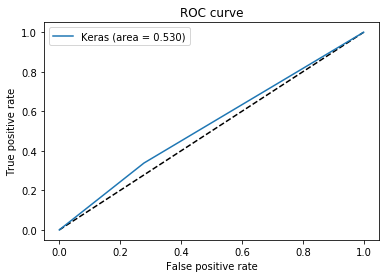

In [30]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt

y_pred_keras = svmd.predict(X_test).ravel()
print(y_pred_keras.shape)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)

auc_keras = auc(fpr_keras, tpr_keras)

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')